In [1]:
import numpy as np
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="5"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [5]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

#from configs import bcolors
#from utils import *
import tensorflow_model_optimization as tfmot

In [6]:
"""ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](
    https://arxiv.org/abs/1512.03385) (CVPR 2016 Best Paper Award)
Adapted from code contributed by BigMoyan.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import warnings

from keras_applications import get_submodules_from_kwargs
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape

preprocess_input = imagenet_utils.preprocess_input

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

backend = None
layers = None
models = None
keras_utils = None

# Load Dataset - Imagenet2012 validation set 50000 images

In [7]:
def preprocess_image(features):
    """Preprocesses the given image.

      Args:
        image: `Tensor` representing an image of arbitrary size.

      Returns:
        A preprocessed image `Tensor` of range [0, 1].
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.keras.applications.resnet.preprocess_input(image)
    
    features["image"] = image
    return features["image"], features["label"]

In [8]:
BATCH_SIZE = 50
tfds_dataset1, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[:40%]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/')
tfds_dataset2, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/')

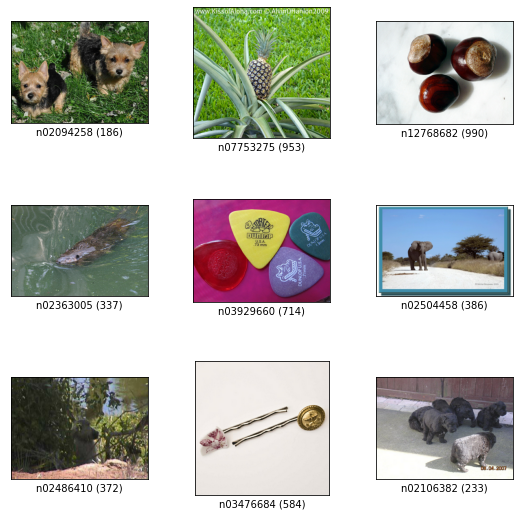

In [9]:
figs = tfds.show_examples(tfds_dataset2, tfds_info)

In [10]:
val_ds = tfds_dataset2.map(preprocess_image).batch(BATCH_SIZE).prefetch(1)
train_ds = tfds_dataset1.map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

In [11]:
def extract(ith_image, ds):
    for i, features in enumerate(ds):
        if ith_image < 50 and i == 0:
            image = np.expand_dims(features[0].numpy()[ith_image], axis=0)
            label = features[1].numpy()[ith_image]
            break
        
        elif i == np.floor(ith_image/50):
            image = np.expand_dims(features["image"].numpy()[ith_image%50], axis=0)
            label = features["label"].numpy()[ith_image%50]
            break
    return image, label

In [12]:
image,label = extract(1,val_ds)

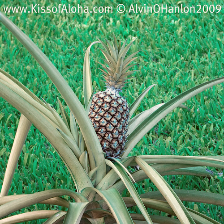

In [13]:
pil_img = tf.keras.preprocessing.image.array_to_img(image[0,:,:,:])
from IPython.display import Image
display(pil_img)

# Goal:

### 1. Construct a tensorflow fp model that shares the weights and structure that the tflite model has. This fp model will act as the 'quantization model' in the semi-bb setting for generating the ad attack.

#### Wei: dequantize weight/bias to fp using scales and zero-points. Quantize activation to int using scales and zero-points, Clip [-128, 127] and dequantize it to fp using scales and zero-points. ‘Do computations with dequantized value’

#### Aahil: Store quantized value in fp format. ‘Do computations with quantized value’



### 2. Before finetunning, the fp model should reach a reseaonable accuracy. This requires a correct inference path. 

### 3. After finetunning, the fp should reach a comparable accuracy as the tflite model has. This requires a correct training path. 

In [14]:
#image = np.random.randint(225, size=(1, 224,224,3))

In [15]:
#image =  tf.keras.applications.imagenet_utils.preprocess_input(image)

# Tfmot (fake_quantization)

In [16]:
import tensorflow_model_optimization as tfmot

In [15]:
q_model = tfmot.quantization.keras.quantize_model(ResNet50(input_shape=(224, 224,3)))

In [16]:
q_model.load_weights("./q_model_40_resnet50.h5")

In [17]:
def Quant_layer(input_tensor,
                scale,
                zero_point):
    scales_r = np.full(backend.int_shape(input_tensor)[1:4], 1/scale,dtype= np.float32)[None,...]
    scales = np.full(backend.int_shape(input_tensor)[1:4], scale,dtype= np.float32)[None,...]
    zero_points = np.full(backend.int_shape(input_tensor)[1:4], zero_point,dtype= np.float32)[None,...]
    
    x = layers.Multiply()([input_tensor, scales_r])
    x = layers.add([x, zero_points])
    x = backend.cast(x,'int32')
    x = backend.clip(x, -128,127)
    x = backend.cast(x,'float32')
    x = layers.subtract([x, zero_points])
    x = layers.Multiply()([x, scales])
    return x

# Input Quantization

In [19]:
outputs = [q_model.get_layer("quant_conv1_pad").input]
model_debug = tf.keras.Model(inputs=q_model.get_layer("input_1").input, outputs=outputs)

#Saving in TFLIte FlatBUffer format with debug information
tflite_mnist_model = "mnist_model_debug.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model_debug)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpl5wwkj3y/assets


INFO:tensorflow:Assets written to: /tmp/tmpl5wwkj3y/assets


In [20]:
with open("./input.tflite", 'wb') as f:
    f.write(tflite_quant_model)

In [21]:
interpreter = tf.lite.Interpreter("./input.tflite")
interpreter.allocate_tensors()
tensor_details = interpreter.get_tensor_details()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

In [22]:
'''
Check input/output details
'''

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: input_1
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [  1 224 224   3]
type: <class 'numpy.float32'>


In [23]:
for dict_ in tensor_details:
    i = dict_['index']
    tensor_name = dict_['name']
    scales = dict_['quantization_parameters']['scales']
    zero_points = dict_['quantization_parameters']['zero_points']
    intweight = interpreter.tensor(i)().copy()
    print(tensor_name,scales,zero_points)

input_1 [] []
model/quantize_layer/AllValuesQuantize/FakeQuantWithMinMaxVars;model/quantize_layer/AllValuesQuantize/FakeQuantWithMinMaxVars/ReadVariableOp/resource;model/quantize_layer/AllValuesQuantize/FakeQuantWithMinMaxVars/ReadVariableOp_1/resource [1.0774157] [-13]
Identity [] []


In [24]:
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])

In [25]:
fp = interpreter.tensor(0)()[0][0][0][1]
print(fp)

42.048027


In [26]:
q = interpreter.tensor(1)()[0][0][0][1]
print(q)

26


In [27]:
fp_ = interpreter.tensor(2)()[0][0][0][1]
print(fp_)

42.01921


In [28]:
q = int(fp/1.0774157 -13)
print(q)

26


In [29]:
(q + 13)*1.0774157

42.0192123

In [30]:
def MyResNet(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):

    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = tf.keras.backend,tf.keras.layers,tf.keras.models,tf.keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    x = Quant_layer(img_input,1.0774157,-13)

    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='myresnet')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [31]:
model = MyResNet(input_shape=(224, 224,3), weights=None)

In [32]:
output_data[0][1][0]

array([-92.65775 ,  29.090223, -36.632133], dtype=float32)

In [33]:
model.predict(image)[0][1][0]

array([-92.65775 ,  29.090223, -35.554718], dtype=float32)

In [34]:
output_data[0][5][223]

array([-31.245056,  72.18685 ,  37.70955 ], dtype=float32)

In [35]:
model.predict(image)[0][5][223]

array([-31.245056,  72.18685 ,  37.70955 ], dtype=float32)

# First Convolution Layer

In [ ]:
outputs = [q_model.get_layer("quant_pool1_pad").input]
model_debug = tf.keras.Model(inputs=q_model.get_layer("input_2").input, outputs=outputs)

#Saving in TFLIte FlatBUffer format with debug information
tflite_mnist_model = "mnist_model_debug.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model_debug)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
with open("./conv.tflite", 'wb') as f:
    f.write(tflite_quant_model)

In [ ]:
interpreter = tf.lite.Interpreter("./conv.tflite")
interpreter.allocate_tensors()
tensor_details = interpreter.get_tensor_details()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

In [ ]:
'''
Check input/output details
'''

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

In [ ]:
for dict_ in tensor_details:
    i = dict_['index']
    tensor_name = dict_['name']
    scales = dict_['quantization_parameters']['scales']
    zero_points = dict_['quantization_parameters']['zero_points']
    intweight = interpreter.tensor(i)().copy()
    print(tensor_name,scales,zero_points)

In [ ]:
def MyResNet(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):

    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = tf.keras.backend,tf.keras.layers,tf.keras.models,tf.keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    x = Quant_layer(img_input,1.0774157,-13)
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal', 
                      name='quant_conv1_conv')(x)
    #x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = Quant_layer(x,0.07133354,-90)
    
    
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='myresnet')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [ ]:
model = MyResNet(input_shape=(224, 224,3), weights=None)

# Fill the weight

In [ ]:
layernames = []
for layer in model.layers:
    if 'quant_conv' in layer.name or 'quant_predictions' in layer.name:
        layernames.append(layer.name)

In [ ]:
weight_dict = {}
for dict_ in tensor_details:
    i = dict_['index']
    tensor_name = dict_['name']
    scales = dict_['quantization_parameters']['scales']
    zero_points = dict_['quantization_parameters']['zero_points']
    intweight = interpreter.tensor(i)().copy()
    for layername in layernames:
        if layername in tensor_name:
            if 'quant_predictions/BiasAdd/ReadVariableOp/resource' in tensor_name:
                weight_dict['quant_predictions/bias:0'] = np.multiply(np.subtract(intweight, zero_points),scales)
                #weight_dict['quant_predictions/bias:0'] = intweight
            elif 'quant_predictions/LastValueQuant' in tensor_name:
                intweight_ = np.moveaxis(intweight, 0, len(intweight.shape)-1)
                weight_dict['quant_predictions/kernel:0'] = (intweight_ - zero_points[0]) *  scales[0]
                #weight_dict['quant_predictions/kernel:0'] = intweight_
                
            else:
                if 'quant_predictions' not in tensor_name and tensor_name.count(layername) ==2:
                    if 'FakeQuantWithMinMaxVarsPerChannel' not in tensor_name:
                        weight_dict[layername + '/bias:0']  = (intweight - zero_points) *  scales
                        #weight_dict[layername + '/bias:0']  = intweight
                    else:
                        intweight_ = intweight - zero_points.reshape((-1,) + (1,) * (intweight.ndim-1))
                        intweight_ = intweight_ * scales.reshape((-1,) + (1,) * (intweight.ndim-1))
                        #intweight_ = intweight
                        w = intweight
                        weight_dict[layername + '/kernel:0']  = np.moveaxis(intweight_, 0, len(intweight_.shape)-1)
for layer in layernames:
    kernel_name = layer + '/kernel:0'
    bias_name = layer + '/bias:0'
    model.get_layer(layer).set_weights( [weight_dict[kernel_name],weight_dict[bias_name]]) 

In [ ]:
b = np.ones(64)
for i in range(0,64):
    b[i] = b[i] + i

In [ ]:
b

In [ ]:
a = b.reshape((-1,) + (1,) * (w.ndim-1))

In [ ]:
w[1][0][0]

In [ ]:
(w*a)[1][0][0]

In [ ]:
for layer in model.layers:
    if layer.name == "quant_conv1_conv":
        print(layer.name)
        print(np.array(model.get_layer(layer.name).get_weights())[0].shape)
        print(np.moveaxis(model.get_layer(layer.name).get_weights()[0], len(model.get_layer(layer.name).get_weights()[0].shape)-1,0).shape)
        print(np.moveaxis(model.get_layer(layer.name).get_weights()[0], len(model.get_layer(layer.name).get_weights()[0].shape)-1,0))
        break

# Intermediate tflite reslut

In [ ]:
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
output_data.shape

In [ ]:
inp = (np.clip((image/1.0774157 -13).astype(int).astype(float),-128,127) + 13)*1.0774157

In [ ]:
outp = (np.clip((model.predict(inp)/0.07133354 - 90).astype(int).astype(float),-128,127) + 90)*0.07133354

In [ ]:
k = outp[0][0][0]

In [ ]:
#k[k < 0] = 0

In [ ]:
k

In [91]:
s = output_data[0][0][0]

In [92]:
s

array([0.49933475, 0.        , 0.        , 0.        , 1.3553371 ,
       3.2813425 , 0.        , 0.        , 0.        , 0.9986695 ,
       3.4240098 , 1.070003  , 0.        , 4.9933476 , 1.9260055 ,
       5.1360145 , 4.0660114 , 1.1413366 , 3.067342  , 0.14266707,
       0.85600245, 4.2086787 , 4.2086787 , 0.        , 2.924675  ,
       1.2126701 , 0.        , 0.        , 0.49933475, 0.78466886,
       3.5666769 , 0.        , 4.3513455 , 0.        , 0.9986695 ,
       0.        , 3.067342  , 0.        , 2.8533413 , 2.7106743 ,
       4.9220138 , 0.        , 0.14266707, 0.        , 1.4980042 ,
       7.1333537 , 1.4980042 , 0.6420018 , 0.        , 5.350015  ,
       0.        , 3.2813425 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.2840036 , 0.        , 6.348685  ,
       0.        , 0.        , 1.2126701 , 1.1413366 ], dtype=float32)

In [80]:
s[s == 4.4703484e-08] = 0

In [93]:
s

array([0.49933475, 0.        , 0.        , 0.        , 1.3553371 ,
       3.2813425 , 0.        , 0.        , 0.        , 0.9986695 ,
       3.4240098 , 1.070003  , 0.        , 4.9933476 , 1.9260055 ,
       5.1360145 , 4.0660114 , 1.1413366 , 3.067342  , 0.14266707,
       0.85600245, 4.2086787 , 4.2086787 , 0.        , 2.924675  ,
       1.2126701 , 0.        , 0.        , 0.49933475, 0.78466886,
       3.5666769 , 0.        , 4.3513455 , 0.        , 0.9986695 ,
       0.        , 3.067342  , 0.        , 2.8533413 , 2.7106743 ,
       4.9220138 , 0.        , 0.14266707, 0.        , 1.4980042 ,
       7.1333537 , 1.4980042 , 0.6420018 , 0.        , 5.350015  ,
       0.        , 3.2813425 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.2840036 , 0.        , 6.348685  ,
       0.        , 0.        , 1.2126701 , 1.1413366 ], dtype=float32)

In [94]:
model.predict(image)[0][0][0]

array([0.4993348 , 0.        , 0.        , 0.        , 1.3553373 ,
       3.3526764 , 0.        , 0.        , 0.        , 0.9986696 ,
       3.42401   , 1.0700032 , 0.        , 4.993348  , 1.9973392 ,
       5.207349  , 4.066012  , 1.1413367 , 3.138676  , 0.14266708,
       0.8560025 , 4.208679  , 4.208679  , 0.        , 2.9960089 ,
       1.2126702 , 0.        , 0.        , 0.4993348 , 0.784669  ,
       3.6380107 , 0.        , 4.4226794 , 0.        , 0.9986696 ,
       0.        , 3.138676  , 0.        , 2.9246752 , 2.7820082 ,
       4.922014  , 0.        , 0.14266708, 0.        , 1.4980044 ,
       7.133354  , 1.569338  , 0.7133354 , 0.        , 5.421349  ,
       0.        , 3.3526764 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.2840037 , 0.        , 6.3486853 ,
       0.        , 0.        , 1.2126702 , 1.1413367 ], dtype=float32)

# First Conv Block

In [278]:
from collections import defaultdict

In [293]:
outputs = [q_model.get_layer("quant_conv2_block2_1_conv").input]
model_debug = tf.keras.Model(inputs=q_model.get_layer("input_2").input, outputs=outputs)

#Saving in TFLIte FlatBUffer format with debug information
tflite_mnist_model = "mnist_model_debug.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model_debug)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
with open("./conv2.tflite", 'wb') as f:
    f.write(tflite_quant_model)
interpreter = tf.lite.Interpreter("./conv2.tflite")
interpreter.allocate_tensors()
tensor_details = interpreter.get_tensor_details()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: D:\Temp\tmp520hvgj_\assets


INFO:tensorflow:Assets written to: D:\Temp\tmp520hvgj_\assets


In [294]:
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])

In [229]:
# r = output_data.copy()
# r.shape

In [295]:
quanti_dict = {}
for dict_ in tensor_details:
    i = dict_['index']
    tensor_name = dict_['name']
    scales = dict_['quantization_parameters']['scales']
    zero_points = dict_['quantization_parameters']['zero_points']
    if tensor_name[-6:] == 'Conv2D':
        name = tensor_name[tensor_name[0:len(tensor_name)-7].rfind('/') + 1:len(tensor_name)-7]
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-7:] == 'Softmax':
        name = 'Softmax'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-3:] == 'add':
        name = tensor_name[tensor_name[0:len(tensor_name)-4].rfind('/') + 1:len(tensor_name)-4]
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-25:] == 'quant_predictions/BiasAdd':
        name = 'FC'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-4:] == 'Mean':
        name = 'Mean'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name == 'resnet50/quant_conv1_pad/Pad':
        name = 'Input'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    #print(tensor_name,scales)

quant_conv1_conv
quant_conv2_block1_0_conv
quant_conv2_block1_1_conv
quant_conv2_block1_2_conv
quant_conv2_block1_3_conv
quant_conv2_block1_add


In [296]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    #conv_name_base = 'res' + str(stage) + block + '_branch'
    #bn_name_base = 'bn' + str(stage) + block + '_branch'

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_1_conv'
    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name)(input_tensor)
    #x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_2_conv'
    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    #x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_3_conv'
    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    x = Quant_layer(x,s,z)
    #x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    conv_name = 'quant_conv' + str(stage) + '_block1_0_conv'
    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name)(input_tensor)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    shortcut = Quant_layer(shortcut,s,z)
    #shortcut = layers.BatchNormalization(
        #axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_add'
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    x = Quant_layer(x,s,z)
    return x


def MyResNet(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):

    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = tf.keras.backend,tf.keras.layers,tf.keras.models,tf.keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    x = Quant_layer(img_input,1.0774157,-13)
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal', 
                      name='quant_conv1_conv')(x)
    #x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = Quant_layer(x,0.07133354,-90)
    
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='1', strides=(1, 1))

    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='myresnet')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model
model = MyResNet(input_shape=(224, 224,3), weights=None)

In [297]:
layernames = []
for layer in model.layers:
    if 'quant_conv' in layer.name or 'quant_predictions' in layer.name:
        layernames.append(layer.name)

weight_dict = {}
for dict_ in tensor_details:
    i = dict_['index']
    tensor_name = dict_['name']
    scales = dict_['quantization_parameters']['scales']
    zero_points = dict_['quantization_parameters']['zero_points']
    intweight = interpreter.tensor(i)().copy()
    for layername in layernames:
        if layername in tensor_name:
            if 'quant_predictions/BiasAdd/ReadVariableOp/resource' in tensor_name:
                weight_dict['quant_predictions/bias:0'] = np.multiply(np.subtract(intweight, zero_points),scales)
                #weight_dict['quant_predictions/bias:0'] = intweight
            elif 'quant_predictions/LastValueQuant' in tensor_name:
                intweight_ = np.moveaxis(intweight, 0, len(intweight.shape)-1)
                weight_dict['quant_predictions/kernel:0'] = (intweight_ - zero_points[0]) *  scales[0]
                #weight_dict['quant_predictions/kernel:0'] = intweight_
                
            else:
                if 'quant_predictions' not in tensor_name and tensor_name.count(layername) ==2:
                    if 'FakeQuantWithMinMaxVarsPerChannel' not in tensor_name:
                        weight_dict[layername + '/bias:0']  = (intweight - zero_points) *  scales
                        #weight_dict[layername + '/bias:0']  = intweight
                    else:
                        intweight_ = intweight - zero_points.reshape((-1,) + (1,) * (intweight.ndim-1))
                        intweight_ = intweight_ * scales.reshape((-1,) + (1,) * (intweight.ndim-1))
                        #intweight_ = intweight
                        w = intweight
                        weight_dict[layername + '/kernel:0']  = np.moveaxis(intweight_, 0, len(intweight_.shape)-1)
for layer in layernames:
    kernel_name = layer + '/kernel:0'
    bias_name = layer + '/bias:0'
    model.get_layer(layer).set_weights( [weight_dict[kernel_name],weight_dict[bias_name]]) 

In [298]:
layernames

['quant_conv1_conv',
 'quant_conv2_block1_1_conv',
 'quant_conv2_block1_2_conv',
 'quant_conv2_block1_3_conv',
 'quant_conv2_block1_0_conv']

In [301]:
s = output_data[0][0][0][0:20]

In [302]:
s

array([0.        , 0.04874454, 0.8286572 , 0.        , 1.3161026 ,
       1.3161026 , 0.2437227 , 0.        , 0.        , 0.6824236 ,
       0.        , 0.        , 1.1211244 , 0.9748908 , 0.        ,
       0.        , 0.        , 1.9497817 , 0.77991265, 0.14623362],
      dtype=float32)

In [316]:
a = model.predict(image)[0][0][0].copy()[0:20]
a[a == -0.0023760302] = 0

In [317]:
a

array([0.        , 0.1438576 , 0.8262812 , 0.        , 1.167493  ,
       1.167493  , 0.24134667, 0.        , 0.        , 0.58255845,
       0.        , 0.        , 1.1187484 , 0.92377025, 0.        ,
       0.        , 0.        , 1.7524275 , 0.7287921 , 0.09511305],
      dtype=float32)

# Every layer except the avgpooling/dense/softmax

In [36]:
outputs = [q_model.get_layer("quant_conv5_block1_1_conv").input]
model_debug = tf.keras.Model(inputs=q_model.get_layer("input_1").input, outputs=outputs)

#Saving in TFLIte FlatBUffer format with debug information
tflite_mnist_model = "mnist_model_debug.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model_debug)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
with open("./conv2.tflite", 'wb') as f:
    f.write(tflite_quant_model)
interpreter = tf.lite.Interpreter("./conv2.tflite")
interpreter.allocate_tensors()
tensor_details = interpreter.get_tensor_details()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

INFO:tensorflow:Assets written to: /tmp/tmpxij3v4ke/assets


INFO:tensorflow:Assets written to: /tmp/tmpxij3v4ke/assets


In [37]:
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])

In [38]:
quanti_dict = {}
for dict_ in tensor_details:
    i = dict_['index']
    tensor_name = dict_['name']
    scales = dict_['quantization_parameters']['scales']
    zero_points = dict_['quantization_parameters']['zero_points']
    if tensor_name[-6:] == 'Conv2D':
        name = tensor_name[tensor_name[0:len(tensor_name)-7].rfind('/') + 1:len(tensor_name)-7]
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-7:] == 'Softmax':
        name = 'Softmax'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-3:] == 'add':
        name = tensor_name[tensor_name[0:len(tensor_name)-4].rfind('/') + 1:len(tensor_name)-4]
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-25:] == 'quant_predictions/BiasAdd':
        name = 'FC'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-4:] == 'Mean':
        name = 'Mean'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name == 'resnet50/quant_conv1_pad/Pad':
        name = 'Input'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    #print(tensor_name,scales)

quant_conv1_conv
quant_conv2_block1_0_conv
quant_conv2_block1_1_conv
quant_conv2_block1_2_conv
quant_conv2_block1_3_conv
quant_conv2_block1_add
quant_conv2_block2_1_conv
quant_conv2_block2_2_conv
quant_conv2_block2_3_conv
quant_conv2_block2_add
quant_conv2_block3_1_conv
quant_conv2_block3_2_conv
quant_conv2_block3_3_conv
quant_conv2_block3_add
quant_conv3_block1_0_conv
quant_conv3_block1_1_conv
quant_conv3_block1_2_conv
quant_conv3_block1_3_conv
quant_conv3_block1_add
quant_conv3_block2_1_conv
quant_conv3_block2_2_conv
quant_conv3_block2_3_conv
quant_conv3_block2_add
quant_conv3_block3_1_conv
quant_conv3_block3_2_conv
quant_conv3_block3_3_conv
quant_conv3_block3_add
quant_conv3_block4_1_conv
quant_conv3_block4_2_conv
quant_conv3_block4_3_conv
quant_conv3_block4_add
quant_conv4_block1_0_conv
quant_conv4_block1_1_conv
quant_conv4_block1_2_conv
quant_conv4_block1_3_conv
quant_conv4_block1_add
quant_conv4_block2_1_conv
quant_conv4_block2_2_conv
quant_conv4_block2_3_conv
quant_conv4_block2_

In [39]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    #conv_name_base = 'res' + str(stage) + block + '_branch'
    #bn_name_base = 'bn' + str(stage) + block + '_branch'

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_1_conv'
    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name)(input_tensor)
    #x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_2_conv'
    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    #x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_3_conv'
    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)
    #x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    conv_name = 'quant_conv' + str(stage) + '_block1_0_conv'
    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name)(input_tensor)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #shortcut = Quant_layer(shortcut,s,z)
    #shortcut = layers.BatchNormalization(
        #axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_add'
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)
    return x

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
        
    #conv_name_base = 'res' + str(stage) + block + '_branch'
    #bn_name_base = 'bn' + str(stage) + block + '_branch'

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_1_conv'
    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name)(input_tensor)
    #x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_2_conv'
    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    #x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_3_conv'
    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)
    #x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_add'
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)
    return x

def MyResNet(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):

    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = tf.keras.backend,tf.keras.layers,tf.keras.models,tf.keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    x = Quant_layer(img_input,1.0774157,-13)
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal', 
                      name='quant_conv1_conv')(x)
    #x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    #x = Quant_layer(x,0.07133354,-90)
    
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='1', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='2')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='3')
    
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='1')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='2')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='3')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='4')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='1')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='2')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='3')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='4')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='5')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='6')

#     x = conv_block(x, 3, [512, 512, 2048], stage=5, block='1')
#     x = identity_block(x, 3, [512, 512, 2048], stage=5, block='2')
#     x = identity_block(x, 3, [512, 512, 2048], stage=5, block='3')

    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='myresnet')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model
model = MyResNet(input_shape=(224, 224,3), weights=None)

In [40]:
layernames = []
for layer in model.layers:
    if 'quant_conv' in layer.name or 'quant_predictions' in layer.name:
        layernames.append(layer.name)

weight_dict = {}
for dict_ in tensor_details:
    i = dict_['index']
    tensor_name = dict_['name']
    scales = dict_['quantization_parameters']['scales']
    zero_points = dict_['quantization_parameters']['zero_points']
    intweight = interpreter.tensor(i)().copy()
    for layername in layernames:
        if layername in tensor_name:
            if 'quant_predictions/BiasAdd/ReadVariableOp/resource' in tensor_name:
                weight_dict['quant_predictions/bias:0'] = np.multiply(np.subtract(intweight, zero_points),scales)
                #weight_dict['quant_predictions/bias:0'] = intweight
            elif 'quant_predictions/LastValueQuant' in tensor_name:
                intweight_ = np.moveaxis(intweight, 0, len(intweight.shape)-1)
                weight_dict['quant_predictions/kernel:0'] = (intweight_ - zero_points[0]) *  scales[0]
                #weight_dict['quant_predictions/kernel:0'] = intweight_
                
            else:
                if 'quant_predictions' not in tensor_name and tensor_name.count(layername) ==2:
                    if 'FakeQuantWithMinMaxVarsPerChannel' not in tensor_name:
                        weight_dict[layername + '/bias:0']  = (intweight - zero_points) *  scales
                        #weight_dict[layername + '/bias:0']  = intweight
                    else:
                        intweight_ = intweight - zero_points.reshape((-1,) + (1,) * (intweight.ndim-1))
                        intweight_ = intweight_ * scales.reshape((-1,) + (1,) * (intweight.ndim-1))
                        #intweight_ = intweight
                        w = intweight
                        weight_dict[layername + '/kernel:0']  = np.moveaxis(intweight_, 0, len(intweight_.shape)-1)
for layer in layernames:
    kernel_name = layer + '/kernel:0'
    bias_name = layer + '/bias:0'
    model.get_layer(layer).set_weights( [weight_dict[kernel_name],weight_dict[bias_name]]) 

In [41]:
layernames

['quant_conv1_conv',
 'quant_conv2_block1_1_conv',
 'quant_conv2_block1_2_conv',
 'quant_conv2_block1_3_conv',
 'quant_conv2_block1_0_conv',
 'quant_conv2_block2_1_conv',
 'quant_conv2_block2_2_conv',
 'quant_conv2_block2_3_conv',
 'quant_conv2_block3_1_conv',
 'quant_conv2_block3_2_conv',
 'quant_conv2_block3_3_conv',
 'quant_conv3_block1_1_conv',
 'quant_conv3_block1_2_conv',
 'quant_conv3_block1_3_conv',
 'quant_conv3_block1_0_conv',
 'quant_conv3_block2_1_conv',
 'quant_conv3_block2_2_conv',
 'quant_conv3_block2_3_conv',
 'quant_conv3_block3_1_conv',
 'quant_conv3_block3_2_conv',
 'quant_conv3_block3_3_conv',
 'quant_conv3_block4_1_conv',
 'quant_conv3_block4_2_conv',
 'quant_conv3_block4_3_conv',
 'quant_conv4_block1_1_conv',
 'quant_conv4_block1_2_conv',
 'quant_conv4_block1_3_conv',
 'quant_conv4_block1_0_conv',
 'quant_conv4_block2_1_conv',
 'quant_conv4_block2_2_conv',
 'quant_conv4_block2_3_conv',
 'quant_conv4_block3_1_conv',
 'quant_conv4_block3_2_conv',
 'quant_conv4_block

In [46]:
a = output_data[0][0][0][0:100]

In [47]:
a[a == 2.0116568e-07] = 0

In [48]:
a

array([0.        , 0.        , 0.        , 0.        , 0.11726278,
       0.17589407, 0.46905053, 0.        , 0.        , 0.        ,
       2.5211456 , 0.35178792, 0.762207  , 0.        , 0.        ,
       0.        , 0.64494437, 0.        , 0.17589407, 0.        ,
       0.17589407, 0.        , 2.990196  , 0.        , 0.64494437,
       0.        , 0.        , 0.11726278, 0.29315665, 0.        ,
       0.        , 0.        , 0.        , 0.11726278, 0.        ,
       0.46905053, 0.64494437, 0.        , 1.0553634 , 0.        ,
       0.46905053, 0.17589407, 0.29315665, 5.2768164 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.762207  ,
       2.579777  , 0.        , 0.17589407, 0.17589407, 2.0520954 ,
       0.        , 2.4625144 , 0.        , 0.35178792, 0.35178792,
       1.6416763 , 0.41041923, 0.        , 0.        , 0.        ,
       0.8208383 , 0.29315665, 0.        , 0.        , 0.        ,
       0.17589407, 0.        , 0.        , 0.17589407, 0.     

In [43]:
s = model.predict(image).copy()[0][0][0][0:100]

In [44]:
#s[s < 0.00000101] = 0.

In [45]:
s

array([0.03129131, 0.        , 0.        , 0.        , 0.06883275,
       0.21792835, 0.41419443, 0.        , 0.        , 0.        ,
       2.497752  , 0.38016185, 0.74076486, 0.        , 0.        ,
       0.        , 0.6319647 , 0.        , 0.15460697, 0.        ,
       0.21097067, 0.        , 3.063009  , 0.        , 0.6254895 ,
       0.        , 0.        , 0.2148019 , 0.35946095, 0.        ,
       0.        , 0.        , 0.        , 0.14270069, 0.        ,
       0.47847405, 0.6407806 , 0.        , 1.0445688 , 0.        ,
       0.5787333 , 0.11318368, 0.18556273, 5.31199   , 0.09888762,
       0.        , 0.        , 0.        , 0.03520873, 0.781153  ,
       2.6805696 , 0.        , 0.16025752, 0.2601116 , 2.0276585 ,
       0.        , 2.5306444 , 0.        , 0.3543368 , 0.30455703,
       1.6075529 , 0.3668217 , 0.        , 0.        , 0.        ,
       0.7886999 , 0.24452603, 0.        , 0.        , 0.        ,
       0.11426891, 0.        , 0.        , 0.21419394, 0.     

# The whole model

In [19]:
interpreter = tf.lite.Interpreter("./tflite_int8_model_40.tflite")
interpreter.allocate_tensors()
tensor_details = interpreter.get_tensor_details()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

In [20]:
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])

In [21]:
quanti_dict = {}
for dict_ in tensor_details:
    i = dict_['index']
    tensor_name = dict_['name']
    scales = dict_['quantization_parameters']['scales']
    zero_points = dict_['quantization_parameters']['zero_points']
    if tensor_name[-6:] == 'Conv2D':
        name = tensor_name[tensor_name[0:len(tensor_name)-7].rfind('/') + 1:len(tensor_name)-7]
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-7:] == 'Softmax':
        name = 'Softmax'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-3:] == 'add':
        name = tensor_name[tensor_name[0:len(tensor_name)-4].rfind('/') + 1:len(tensor_name)-4]
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-25:] == 'quant_predictions/BiasAdd':
        name = 'FC'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name[-4:] == 'Mean':
        name = 'Mean'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    elif tensor_name == 'resnet50/quant_conv1_pad/Pad':
        name = 'Input'
        quanti_dict[name] = {}
        quanti_dict[name]['scales'] = scales[0]
        quanti_dict[name]['zero_points'] = zero_points[0]
        print(name)
    #print(tensor_name,scales)

Input
quant_conv1_conv
quant_conv2_block1_0_conv
quant_conv2_block1_1_conv
quant_conv2_block1_2_conv
quant_conv2_block1_3_conv
quant_conv2_block1_add
quant_conv2_block2_1_conv
quant_conv2_block2_2_conv
quant_conv2_block2_3_conv
quant_conv2_block2_add
quant_conv2_block3_1_conv
quant_conv2_block3_2_conv
quant_conv2_block3_3_conv
quant_conv2_block3_add
quant_conv3_block1_0_conv
quant_conv3_block1_1_conv
quant_conv3_block1_2_conv
quant_conv3_block1_3_conv
quant_conv3_block1_add
quant_conv3_block2_1_conv
quant_conv3_block2_2_conv
quant_conv3_block2_3_conv
quant_conv3_block2_add
quant_conv3_block3_1_conv
quant_conv3_block3_2_conv
quant_conv3_block3_3_conv
quant_conv3_block3_add
quant_conv3_block4_1_conv
quant_conv3_block4_2_conv
quant_conv3_block4_3_conv
quant_conv3_block4_add
quant_conv4_block1_0_conv
quant_conv4_block1_1_conv
quant_conv4_block1_2_conv
quant_conv4_block1_3_conv
quant_conv4_block1_add
quant_conv4_block2_1_conv
quant_conv4_block2_2_conv
quant_conv4_block2_3_conv
quant_conv4_b

In [22]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    #conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_1_conv'
    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name)(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)
    #s = quanti_dict[conv_name]['scales']
    #z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_2_conv'
    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)
    #s = quanti_dict[conv_name]['scales']
    #z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_3_conv'
    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    conv_name = 'quant_conv' + str(stage) + '_block1_0_conv'
    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name)(input_tensor)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #shortcut = Quant_layer(shortcut,s,z)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_add'
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)
    return x

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
        
    #conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_1_conv'
    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name)(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_2_conv'
    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)

    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_3_conv'
    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name)(x)
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    conv_name = 'quant_conv' + str(stage) + '_block' + str(block) + '_add'
    s = quanti_dict[conv_name]['scales']
    z = quanti_dict[conv_name]['scales']
    #x = Quant_layer(x,s,z)
    return x

def MyResNetFinal(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):

    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = tf.keras.backend,tf.keras.layers,tf.keras.models,tf.keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    #x = Quant_layer(img_input,1.0774157,-13)
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal', 
                      name='quant_conv1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    #x = Quant_layer(x,0.07133354,-90)
    
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='1', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='2')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='3')
    
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='1')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='2')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='3')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='4')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='1')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='2')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='3')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='4')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='5')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='6')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='1')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='2')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='3')
    
    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation = 'softmax',name='quant_predictions')(x)

    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='myresnet')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model
model = MyResNetFinal(input_shape=(224, 224,3), weights=None)

In [23]:
layernames = []
for layer in model.layers:
    if 'quant_conv' in layer.name or 'quant_predictions' in layer.name:
        layernames.append(layer.name)

weight_dict = {}
for dict_ in tensor_details:
    i = dict_['index']
    tensor_name = dict_['name']
    scales = dict_['quantization_parameters']['scales']
    zero_points = dict_['quantization_parameters']['zero_points']
    intweight = interpreter.tensor(i)().copy()
    for layername in layernames:
        if layername in tensor_name:
            if 'quant_predictions/BiasAdd/ReadVariableOp/resource' in tensor_name:
                weight_dict['quant_predictions/bias:0'] = np.multiply(np.subtract(intweight, zero_points),scales)
                #weight_dict['quant_predictions/bias:0'] = intweight
            elif 'quant_predictions/LastValueQuant' in tensor_name:
                intweight_ = np.moveaxis(intweight, 0, len(intweight.shape)-1)
                weight_dict['quant_predictions/kernel:0'] = (intweight_ - zero_points[0]) *  scales[0]
                #weight_dict['quant_predictions/kernel:0'] = intweight_
                
            else:
                if 'quant_predictions' not in tensor_name and tensor_name.count(layername) ==2:
                    if 'FakeQuantWithMinMaxVarsPerChannel' not in tensor_name:
                        weight_dict[layername + '/bias:0']  = (intweight - zero_points) *  scales
                        #weight_dict[layername + '/bias:0']  = intweight
                    else:
                        intweight_ = intweight - zero_points.reshape((-1,) + (1,) * (intweight.ndim-1))
                        intweight_ = intweight_ * scales.reshape((-1,) + (1,) * (intweight.ndim-1))
                        #intweight_ = intweight
                        w = intweight
                        weight_dict[layername + '/kernel:0']  = np.moveaxis(intweight_, 0, len(intweight_.shape)-1)
for layer in layernames:
    kernel_name = layer + '/kernel:0'
    bias_name = layer + '/bias:0'
    model.get_layer(layer).set_weights( [weight_dict[kernel_name],weight_dict[bias_name]]) 

In [24]:
np.argmax(output_data)

953

In [25]:
np.argmax(model.predict(image))

953

In [26]:
model.predict(image).shape

(1, 1000)

In [27]:
output_data.shape

(1, 1000)

In [31]:
def eval2(model,q_model, ds, batch_size):# evalute instability
    accurate_pred = set()
    accurate_q_pred = set()
    for n, features in enumerate(ds):
        logits = model.predict(features[0])
        q_logits = q_model.predict(features[0])
        p = [(i + n*batch_size) for i, j in enumerate(zip(list(tf.argmax(logits, axis=-1).numpy()),list(features[1].numpy()))) if all(j[0]==k for k in j[1:])]
        q_p = [(i + n*batch_size) for i, j in enumerate(zip(list(tf.argmax(q_logits, axis=-1).numpy()),list(features[1].numpy()))) if all(j[0]==k for k in j[1:])]
        accurate_pred.update(p)
        accurate_q_pred.update(q_p)
        if (n + 1) % 50 == 0:
            print("Finished %d examples" % ((n + 1) * batch_size))
    q_correct = len(accurate_q_pred)
    orig_correct = len(accurate_pred)
    q_correct_orig_wrong = len(accurate_q_pred.difference(accurate_pred))
    q_wrong_orig_correct = len(accurate_pred.difference(accurate_q_pred))
    return q_correct, orig_correct, q_correct_orig_wrong, q_wrong_orig_correct

In [27]:
BATCH_SIZE = 50
es = {'file_name': tf.TensorSpec(shape=(), dtype=tf.string, name=None),
 'image': tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 'label': tf.TensorSpec(shape=(), dtype=tf.int64, name=None)}
train_ds = tf.data.experimental.load("/local/rcs/wei/last60p27k/",es).map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

In [28]:
from SemibbModel import * 

In [38]:
model = buildmodel('fp')
model.load_weights("/home/wei.hao/Torch_to_TF/ResNet50.h5")

In [39]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [45]:
for l in model.layers:
    if l.name != 'bn_conv1':
        l.trainable = False

In [47]:
for l in model.layers:
    print(l.name, l.trainable)

input_4 False
conv1_pad False
quant_conv1_conv False
bn_conv1 True
activation_104 False
pool1_pad False
max_pooling2d_3 False
quant_conv2_block1_1_conv False
bn21_branch2a False
activation_105 False
quant_conv2_block1_2_conv False
bn21_branch2b False
activation_106 False
quant_conv2_block1_3_conv False
quant_conv2_block1_0_conv False
bn21_branch2c False
bn21_branch1 False
add_33 False
activation_107 False
quant_conv2_block2_1_conv False
bn22_branch2a False
activation_108 False
quant_conv2_block2_2_conv False
bn22_branch2b False
activation_109 False
quant_conv2_block2_3_conv False
bn22_branch2c False
add_34 False
activation_110 False
quant_conv2_block3_1_conv False
bn23_branch2a False
activation_111 False
quant_conv2_block3_2_conv False
bn23_branch2b False
activation_112 False
quant_conv2_block3_3_conv False
bn23_branch2c False
add_35 False
activation_113 False
quant_conv3_block1_1_conv False
bn31_branch2a False
activation_114 False
quant_conv3_block1_2_conv False
bn31_branch2b False
ac

In [22]:
dq_model = tfmot.quantization.keras.quantize_model(model)

In [23]:
dq_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [32]:
eval2(model,q_model,val_ds,50)

Finished 2500 examples
Finished 5000 examples
Finished 7500 examples
Finished 10000 examples
Finished 12500 examples
Finished 15000 examples
Finished 17500 examples
Finished 20000 examples
Finished 22500 examples
Finished 25000 examples
Finished 27500 examples
Finished 30000 examples


(21043, 21285, 619, 861)

In [34]:
model.load_weights("./segregated_fp_model_40_resnet_1.h5")

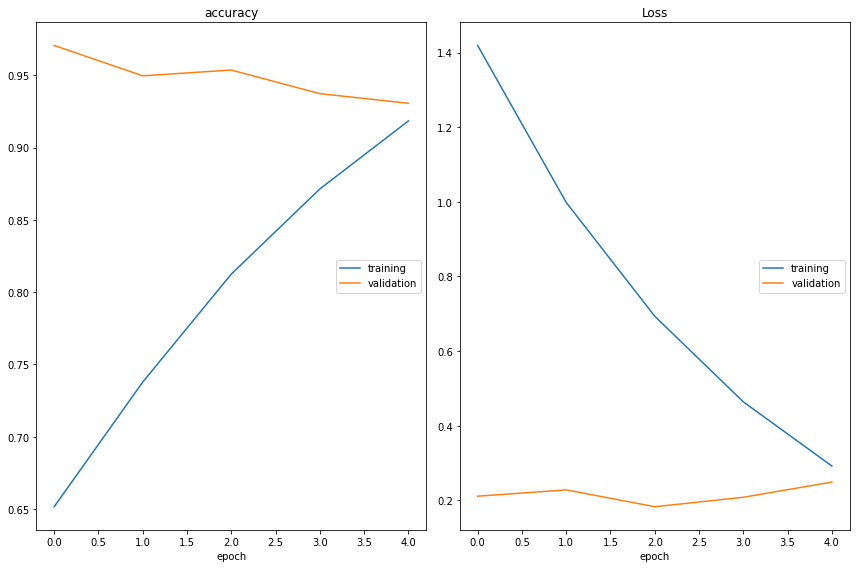

accuracy
	training         	 (min:    0.652, max:    0.918, cur:    0.918)
	validation       	 (min:    0.931, max:    0.971, cur:    0.931)
Loss
	training         	 (min:    0.292, max:    1.419, cur:    0.292)
	validation       	 (min:    0.183, max:    0.249, cur:    0.249)


In [31]:
from livelossplot import PlotLossesKeras
# checkpoint_path = "./segregated_fp_model_40_resnet{epoch:02d}-{val_loss:.2f}.hf"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
model.fit(train_ds,validation_data= val_ds, epochs=5 ,callbacks=[PlotLossesKeras()])

In [45]:
q_model.save('./differentialble_q_model_40_resnet.h5')

In [32]:
model.save('./segregated_fp_model_40_resnet_2_v2.h5')

In [30]:
#model.save('./differentiable_q_model_40_resnet_2.h5')

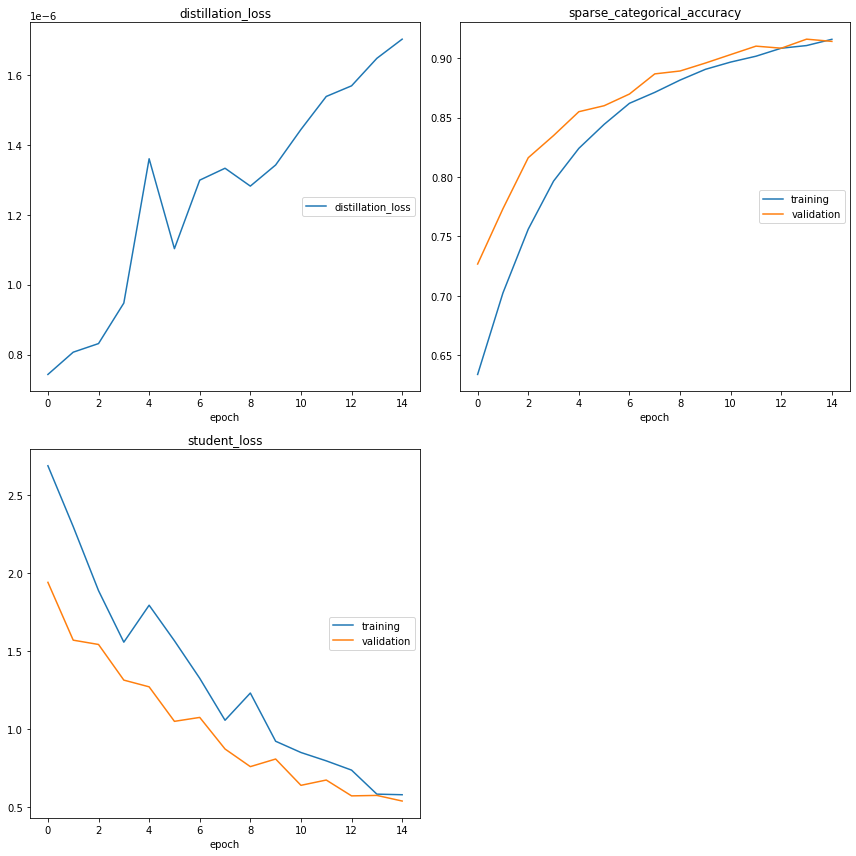

distillation_loss
	distillation_loss 	 (min:    0.000, max:    0.000, cur:    0.000)
sparse_categorical_accuracy
	training         	 (min:    0.634, max:    0.916, cur:    0.916)
	validation       	 (min:    0.727, max:    0.916, cur:    0.914)
student_loss
	training         	 (min:    0.581, max:    2.687, cur:    0.581)
	validation       	 (min:    0.541, max:    1.941, cur:    0.541)


In [79]:
from livelossplot import PlotLossesKeras
distiller = Distiller(student=model, teacher=q_model)
distiller.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)
# Distill teacher to student
distiller.fit(train_ds,validation_data= val_ds, epochs=15 ,callbacks=[PlotLossesKeras()])

In [40]:
model.evaluate(val_ds)

600/600 [==============================] - 109s 180ms/step - loss: 519.6958 - sparse_categorical_accuracy: 8.3077e-04


[520.192626953125, 0.0009666666737757623]

In [43]:
model.save('./segregated_fp_model_40_resnet.h5')

In [21]:
BATCH_SIZE = 50
es = {'file_name': tf.TensorSpec(shape=(), dtype=tf.string, name=None),
 'image': tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 'label': tf.TensorSpec(shape=(), dtype=tf.int64, name=None)}
val_ds = tf.data.experimental.load("/local/rcs/wei/End3kImagePerClass/",es).map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

In [28]:
cs = 0
for n, features in enumerate(val_ds):
    l = tf.keras.applications.resnet.decode_predictions(model.predict(features[0]), top=1)
    cs += sum(val[0][2] for index, val in enumerate(l))
    if (n + 1) % 50 == 0:
        print(cs/((n + 1) * 50))

0.893785675984621


In [29]:
cs/3000

0.8955589230209589